## Notebook to adjust PlanetScope images using a hillshade model and expected surface reflectance of snow

Rainey Aberle

Summer 2022

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from shapely.geometry import Polygon
from scipy.interpolate import interp2d
import time
import rasterio as rio
import geopandas as gpd
import sys

### Define paths in directory, snow-covered area (SCA), and settings

In [2]:
# ----Define ID for study site (used in output file names)
site_ID = 'WG'

# -----Define paths in directory
# path to planet-snow/ directory
base_path = '/Users/raineyaberle/Research/PhD/planet-snow/'
# path to raw PlanetScope images
im_path = base_path+'../study-sites/Wolverine/imagery/Planet/2021-04-20_2021-08-25/PSScene4Band/'
# path to Area of Interest (AOI) shapefile, e.g. glacier outline (optional)
SCA_path = '/Users/raineyaberle/Research/PhD/Wolverine/GIS_data/wolverine_RGI.shp'
# path to hillshades directory
hs_path = im_path+'../hillshades/'
# output folder
out_path = im_path+'../hillshade-corrected/'

# -----Define snow-covered area (SCA) 
SCA = Polygon([(393.5e3, 6699e3), (393.5e3, 6701e3), (395.5e3, 6701e3), (395.5e3, 6699e3), (393.5e3, 6699e3)])

# -----Determine settings
plot_results = True # = True to plot corrected images
hillshade_correction = True # = True to apply hillshade correction using a DEM
# path to DEM - required if hillshade_correction = True
DEM_path = base_path+'../study-sites/Wolverine/DEMs/WG_20200728-DEM_mosaic_crop_UTM6_resamp_filled.tif'
adjust_radiometry = True # = True to adjust image band radiometry using the SCA
max_cloud_cover = 20.0 # [%] maximum image cloud cover - if cloud cover > max_cloud_cover, image is skipped

# -----Add path to functions
sys.path.insert(1, base_path+'functions/')
from image_adjustment_utils import sunpos, into_range, apply_hillshade_correction, adjust_image_radiometry

### Load DEM, PlanetScope images and metadata

DEM CRS:  EPSG:32606
Images CRS: EPSG:32606


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


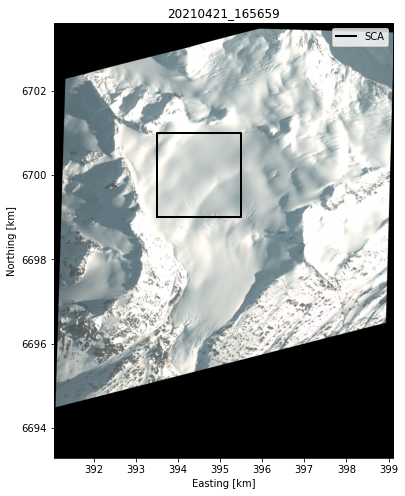

In [3]:
# -----Define CRS (EPSG code)
CRS = 32606

# -----Load DEM
DEM = rio.open(DEM_path)
# coordinates
DEM_x = np.linspace(DEM.bounds.left, DEM.bounds.right, num=np.shape(DEM.read(1))[1])
DEM_y = np.linspace(DEM.bounds.top, DEM.bounds.bottom, num=np.shape(DEM.read(1))[0])

# -----Load images
ims = os.chdir(im_path) # change directory
im_names = glob.glob('*SR*.tif') # load all SR files
im_names.sort() # sort file names by date
meta_names = glob.glob('*metadata*.xml') # load all metadata files
meta_names.sort() # sort file names by date

# -----Print coordinate reference systems to ensure they are the same
print('DEM CRS: ',DEM.crs)
print('Images CRS:',rio.open(im_names[0]).crs)

# -----Read one image and plot AOI
im_name = im_names[1]
im = rio.open(im_name)
im_scalar = 10000
b = im.read(1).astype(float)
g = im.read(2).astype(float)
r = im.read(3).astype(float)
nir = im.read(4).astype(float)
# divide by im_scalar if they have not been already
if (np.nanmean(b)>1e3):
    b = b / im_scalar
    g = g / im_scalar
    r = r / im_scalar
    nir = nir / im_scalar
# define coordinates grid
im_x = np.linspace(im.bounds.left, im.bounds.right, num=np.shape(b)[1])
im_y = np.linspace(im.bounds.top, im.bounds.bottom, num=np.shape(b)[0])
# plot
fig, ax1 = plt.subplots(1, 1, figsize=(8,8))
ax1.imshow(np.dstack([r, g, b]), 
           extent=(np.min(im_x)/1000, np.max(im_x)/1000, np.min(im_y)/1000, np.max(im_y)/1000))
ax1.plot([x/1000 for x in SCA.exterior.xy[0]], [y/1000 for y in SCA.exterior.xy[1]], 
         color='black', linewidth=2, label='SCA')
ax1.set_xlabel('Easting [km]')
ax1.set_ylabel('Northing [km]')
ax1.set_title(im_name[0:15])
ax1.legend()
plt.show()

### Loop through images

Image:  20210421_165658_0f21_3B_AnalyticMS_SR_clip.tif
HILLSHADE CORRECTION
image does not contain SCA... skipping.
----------
 
Image:  20210421_165659_0f21_3B_AnalyticMS_SR_clip.tif
HILLSHADE CORRECTION
hillshade model already exists in directory, loading...
hillshade model loaded from file...
resampled hillshade model already exists in directory, loading...
resampled hillshade model loaded from file
solving for optimal band scalars...
Scalars:  Blue   |   Green   |   Red   |   NIR
0.15000000000000002 0.17500000000000002 0.225 0.225
correcting bands using optimal scalar...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


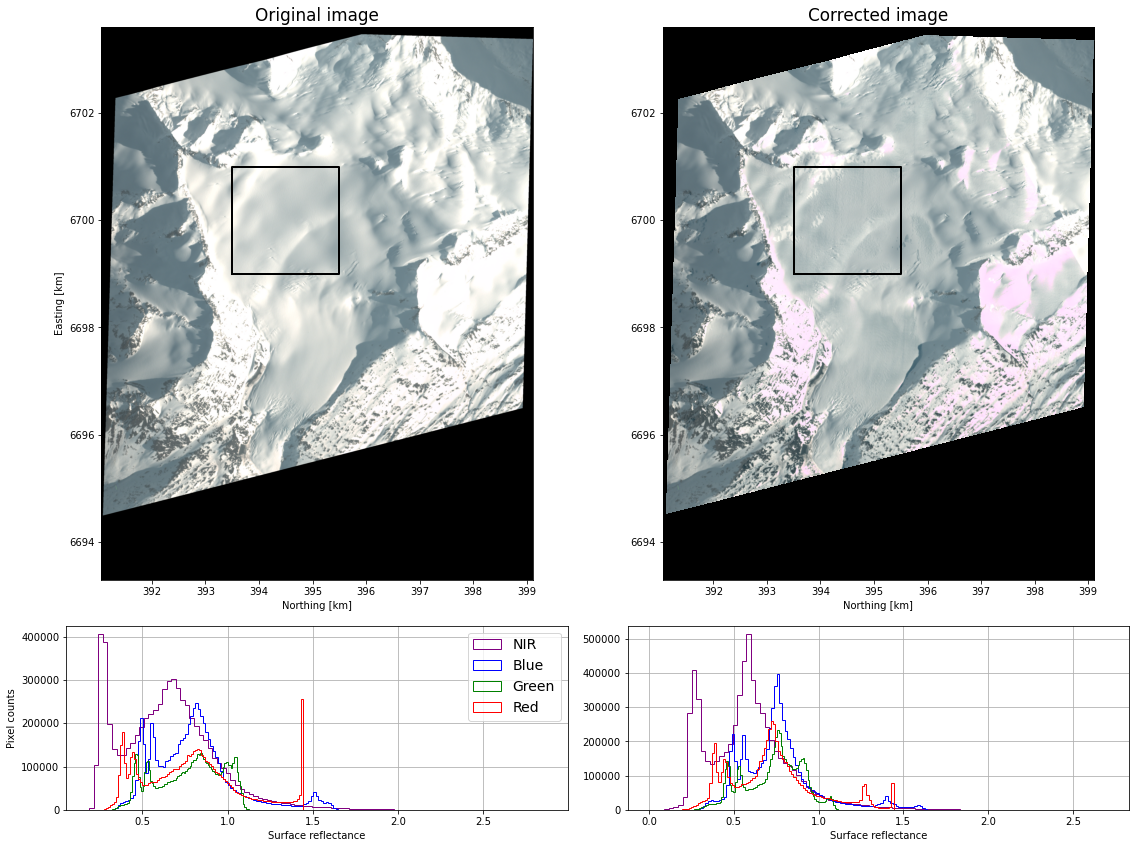

adjusted image saved to file:/Users/raineyaberle/Research/PhD/planet-snow/../study-sites/Wolverine/imagery/Planet/2021-04-20_2021-08-25/PSScene4Band/../adjusted-filtered/20210421_165659_0f21_3B_AnalyticMS_SR_clip_hs-corrected.tif
RADIOMETRIC ADJUSTMENT


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


nan
False
no real values within SCA... skipping.
----------
 
Image:  20210421_165700_0f21_3B_AnalyticMS_SR_clip.tif
HILLSHADE CORRECTION
image does not contain SCA... skipping.
----------
 
Image:  20210421_202734_37_2423_3B_AnalyticMS_SR_clip.tif
HILLSHADE CORRECTION
hillshade model already exists in directory, loading...
hillshade model loaded from file...
resampled hillshade model already exists in directory, loading...
resampled hillshade model loaded from file
solving for optimal band scalars...
Scalars:  Blue   |   Green   |   Red   |   NIR
0.0 0.0 0.05 0.07500000000000001
correcting bands using optimal scalar...


KeyboardInterrupt: 

In [4]:
# -----Start timer
t1 = time.monotonic()

# -----Loop through images
for im_name in im_names:
    
    # load image
    print('Image: ',im_name)
    im = rio.open(im_name)
    
    # load metadata
    for meta_name in meta_names:
        if im_name[0:24] in meta_name:
            # open the sample file used
            meta = open(meta_name)
            meta_content = meta.readlines()
    
    # apply hillshade correction
    if (hillshade_correction == True):
        im_corrected_name, im_corrected_path = apply_hillshade_correction(meta_content, max_cloud_cover, CRS, SCA, im, im_name, im_path, DEM_path, plot_results)
        if im_corrected_name=='N/A':
            print('----------')
            print(' ')            
            continue
        else:
            im_corrected = rio.open(im_corrected_name)
    
    # adjust radiometry
    if (adjust_radiometry == True):
        if (hillshade_correction==True):
            im_corrected_name, im_corrected_path = adjust_image_radiometry(meta_content, max_cloud_cover, im_corrected, im_corrected_name, im_corrected_path, SCA, plot_results)
        else:
            im_corrected_name, im_corrected_path = adjust_image_radiometry(meta_content, max_cloud_cover, im, im_name, im_path, SCA, plot_results)
    
    print('----------')
    print(' ')

# -----Stop timer
t2 = time.monotonic()
print('Time elapsed: ',str(round(t2-t1)/60),'minutes ')
    